# Pulsar Timing with PINT

Compiled by Lydia Guertin in 2023 using the [basic PINT tutorial](https://nanograv-pint.readthedocs.io/en/latest/examples/time_a_pulsar.html), comments from Mae Hagelgans, and some lessons learned along the way.

# Introduction
**Pulsar Timing** is basically tracking every single rotation of a pulsar. From a pulsar observation, we calculate the times of arrival (**TOAs**) of pulses from that pulsar. Every pulse is related to a certain rotation of the pulsar.

During pulsar timing, we generate a model that can accurately calculate the pulse number corresponding to each TOA and also predict when a particular pulse in the future will arrive. This model is calculated by minimizing the residuals:

**residual = observed TOA - model predicted TOA**.

We start from a basic timing model (**.par file**) for the pulsar and calculate the residuals for a set of measured TOAs (**.tim file**). Then we fit for different parameters in the model to minimize the residuals.

The errors in different parameters in the .par file give rise to different shapes in the residuals. We can look at the shape of the residuals to decide which parameter we should fit for, but in general a good timing model fit will have residuals centered around zero with minimal scatter. Let's get into it!

In [2]:
# Importing necessary packages
from pint.models import get_model_and_toas
from pint.residuals import Residuals
import pint.fitter
import matplotlib.pyplot as plt
import astropy.units as u
import pint.logging
pint.logging.setup(level="WARNING") 
'''This last line tells it to print any warnings encountered -- they will be printed in red, but they're not errors!'''

"This last line tells it to print any warnings encountered -- they will be printed in red, but they're not errors!"

# Initial Setup: what your files should look like

We'll be using the included example files for this tutorial, but for the sake of argument (and your own data), here are some examples of what your .par (parameter) and .tim (TOA) files should look like.

## .par files

There are a lot of potential entries for parameter files included in PINT -- for a full list, you can check [this page](https://nanograv-pint.readthedocs.io/en/latest/_autosummary/pint.models.parameter.Parameter.html#pint.models.parameter.Parameter). For almost every system, you'll want values for RA, Dec, F0, F1, and DM, even if you don't have the multifrequency data necessary to fit for DM in the actual running of PINT. Here is a very basic example parameter file, pulled from the [ATNF catalogue](https://www.atnf.csiro.au/people/pulsar/psrcat/) with some updated values pulled from the [Jodrell Bank Observatory crab pulsar monitoring program](https://www.jb.man.ac.uk/pulsar/crab/crab2.txt):

PSRJ            J0534+2200 

RAJ             05:34:31.973           1      5.000e-03

DECJ            +22:00:52.06           1      6.000e-02

DM              56.7278                       2.400e-04

PEPOCH          48442.5             

F0              29.581330165                  1.000e-06

F1              -3.77535E-10           1      2.000e-15

PMRA            -14.7                         8.000e-01

PMDEC           2.0                           8.000e-01

POSEPOCH        40706

DMEPOCH         56703

F2              1.1147E-20                    5.000e-24

EPHEM           DE405

RM              -45.44                        8.000e-02

F3              -2.73E-30                     4.000e-32

EPHVER          2

UNITS           TDB

The four columns are (from left to right) the parameter name, the value, a binary (0 or 1, with 0 everywhere there is not a 1) parameter telling PINT which parameters to fit (1 is fit, empty/0 is not fit), and the error. The only thing you should be manually changing from these .par files at this stage is the 0/1 to designate which parameters you want to fit for, usually beginning with RA/Dec or F0 and then expanding once you get a good fit for those.

## .tim files

There are similarly two different file formats available for PINT to specify how to read these files -- they're called the Princeton (TEMPO) format and Tempo2 format. Tempo2 format is specified by putting "FORMAT 1" directly into the files at the very top, and the other format(s? I couldn't quite tell if there are more [from the documentation](https://nanograv-pint.readthedocs.io/en/latest/_autosummary/pint.toa.TOAs.html#pint.toa.TOAs.write_TOA_file)) are designated by the arrangement of columns and data itself. The minimum requirements for data in a .tim file are the observatory name, the observing center frequency, the actual TOAs, and the TOA error. Here's an example from a Crab pulsar timing project:

FORMAT 1

unk               1550.244 59804.6201464833765    90.00 gbt

unk               1550.244 59804.6227313428241    81.32 gbt

unk               1550.244 59804.6253165921864    96.42 gbt

unk               1550.244 59804.6279014495942   137.02 gbt

unk               1550.244 59804.6304863050731   152.18 gbt

unk               1550.244 59804.6330711660626   130.69 gbt

unk               1550.244 59804.6356560264744    95.18 gbt

unk               1550.244 59804.6382412765682   107.96 gbt

unk               1550.244 59805.5943016290745    85.41 gbt

unk               1550.244 59805.5968864864275   103.63 gbt

unk               1550.244 59805.5994717375568   109.73 gbt

unk               1550.244 59805.6020565941645   110.82 gbt

unk               1550.244 59805.6046414534716    78.38 gbt

unk               1550.244 59805.6072263137318   114.33 gbt

unk               1550.244 59805.6098111701981   120.63 gbt

unk               1550.244 59805.6123964209387    79.92 gbt

The columns, from left to right, are the file name associated with the individual TOAs, which we have set to "unk" since they're all collected into a single file that we pass directly to PINT, the observing frequency, the TOAs in units of MJD, the TOA errors in units of microseconds, and the [observatory identifier string.](https://nanograv-pint.readthedocs.io/en/latest/observatory_list.html)

In [3]:
'''Specifying timing model (.par file) and TOAs (.tim file) to use. Since we're using the included example file, we
have to first import the config module, but you usually don't need this import for your own data!'''
import pint.config

#make sure to go into par file and list a 1 next to the parameter you want to fit for
parfile = 'B0531_59899_59928.par'
#then
#parfile = 'output.par'
timfile = 'window.tim'


'''
parfile = "filename.par"
timfile = "filename.tim"
'''

# Creating PINT model (m) and TOA (t_all) object
m, t_all = get_model_and_toas(parfile, timfile)

# And printing so we can see our initial timing model parameters
print(m)

WARNING  (pint.logging                  ): /opt/conda/lib/python3.10/site-packages/pint/models/model_builder.py:198 UserWarning: Unrecognized parfile line 'EPHVER 2'


# Created: 2024-06-07T22:16:10.987389
# PINT_version: 0.9.8+175.gc50630d7
# User: jovyan
# Host: dd38cd490352
# OS: Linux-4.18.0-425.13.1.el8_7.x86_64-x86_64-with-glibc2.31
# Python: 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]
# Format: pint
PSRJ                           J0534+2200
EPHEM                               DE405
UNITS                                 TDB
RM                                 -45.44 0 0.08
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                      5:34:31.97300000 0 0.00499999999999999924
DECJ                    22:00:52.06000000 0 0.05999999999999999778
PMRA                                -14.7 0 0.8
PMDEC                                 2.0 0 0.8
PX                                    0.0
POSEPOCH           40706.0000000000000000
F0                          29.5784110377 1 1e-06
F1                          -3.671988e-10 0 2e-15
F2       

In [4]:
# We can also see a summary of all our TOAs, which can be helpful once we start fitting for parameters
t_all.print_summary()

Number of TOAs:  4
Number of commands:  1
Number of observatories: 1 ['gbt']
MJD span:  59905.063 to 59905.078
Date span: 2022-11-22 01:30:18.318371707 to 2022-11-22 01:52:38.337404948
gbt TOAs (4):
  Min freq:      1550.244 MHz
  Max freq:      1550.244 MHz
  Min error:     65.4 us
  Max error:     94.5 us
  Median error:  81.2 us



In [5]:
# We've got a few TOAs with higher errors than are desireable, so we're going to impose a cut to create a new TOA 
# object with only those TOAs whose errors are less than whatever threshold we want (here 100 microseconds)
error_ok = t_all.table["error"] <= 100 * u.us
t = t_all[error_ok]
t.print_summary()

Number of TOAs:  4
Number of commands:  1
Number of observatories: 1 ['gbt']
MJD span:  59905.063 to 59905.078
Date span: 2022-11-22 01:30:18.318371707 to 2022-11-22 01:52:38.337404948
gbt TOAs (4):
  Min freq:      1550.244 MHz
  Max freq:      1550.244 MHz
  Min error:     65.4 us
  Max error:     94.5 us
  Median error:  81.2 us



We can see that this cut got rid of only one TOA, which is great. Make sure to check how these cuts affect your TOAs, as you don't want to end up with too few. We also retained the original TOA object by just creating a new variable t rather than overwriting t_all, so we can always tinker with both to see how the timing model is affected by outliers that we cut out. 

all TOA residuals max value = 583.4964457951963445
cut TOA residuals max value = 583.4964457951963445


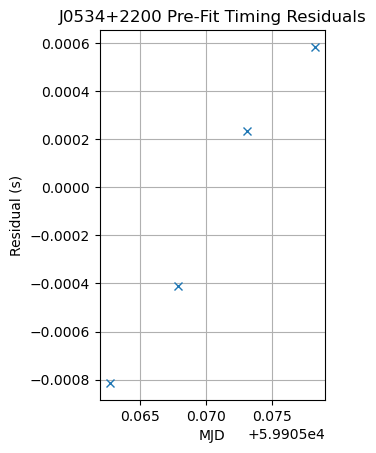

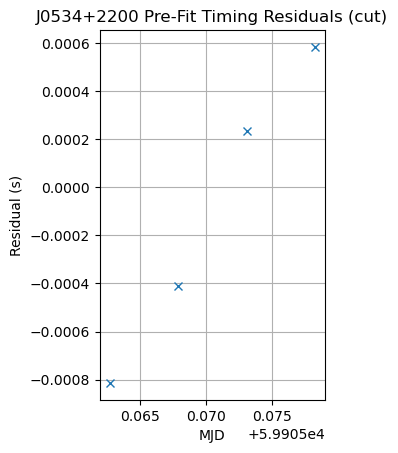

In [6]:
# Calculating the timing residuals = observed TOAs - model predicted TOAs
rs = Residuals(t_all, m)
print("all TOA residuals max value = "+str(rs.resids.to(u.us).value.max())) # This is useful to later see if your new 
# model has improved your residuals when they're too similar to see the changes by eye
xt = t_all.get_mjds() # TOAs in MJD to plot

# we can do the same for our slice of TOAs with acceptable errors to see exactly how this has changes our residuals
rs_cut = Residuals(t, m)
print("cut TOA residuals max value = "+str(rs_cut.resids.to(u.us).value.max()))
xt_cut = t.get_mjds() 

# Plotting the residuals next to each other
plt.subplot(121)
plt.plot(xt, rs.resids, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()
plt.subplot(122)
plt.plot(xt_cut, rs_cut.resids, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals (cut)")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()

In [7]:
# Printing some helpful statistics
print(f"Chi-square = {rs.calc_chi2()}")
print(f"Reduced Chi-square = {rs.reduced_chi2}")
print(f"WRMS = {rs.rms_weighted()}")

Chi-square = 208.44111496992676
Reduced Chi-square = 104.22055748496338
WRMS = 566.617116300222 us


In [8]:
# Creating PINT fitter object "f"
f = pint.fitter.Fitter.auto(t_all, m)
# Fitting the TOAs by changing model parameters and reevaluating if the chi-square value improves
f.fit_toas()
# Printing summary of the fitting
f.print_summary()

Fitted model using downhill_wls method with 1 free parameters to 4 TOAs
Prefit residuals Wrms = 566.617116300222 us, Postfit residuals Wrms = 57.60899748727304 us
Chisq = 2.155 for 2 d.o.f. for reduced Chisq of 1.077

PAR                   Prefit                  Postfit            Units
============== ==================== ============================ =====
PSR                      J0534+2200 J0534+2200                   None
EPHEM                         DE405 DE405                        None
CLOCK                               TT(BIPM2021)                 None
UNITS                           TDB TDB                          None
START                                                    59905.1 d 
FINISH                                                   59905.1 d 
RM                           -45.44                              rad / m2 
DILATEFREQ                        N                              None
DMDATA                            N                              None
NTOA     

You'll notice that fitting for RA, Dec, F0, and F1 allows us to derive a few different physical parameters. If you only fit for F0, for example, you'll only be able to derive the period, as well as likely having a worse fit overall. We can also see that our weighted root mean squared (wrms) of the residuals has decreased by two whole orders of magnitude, which is a great sign!

Post-fit residual max value = 95.72992642625477169
All TOA pre-fit residuals max value = 583.4964457951963445


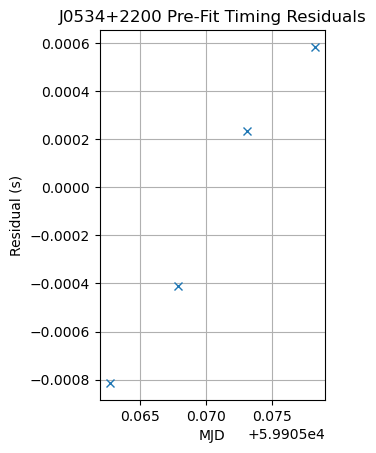

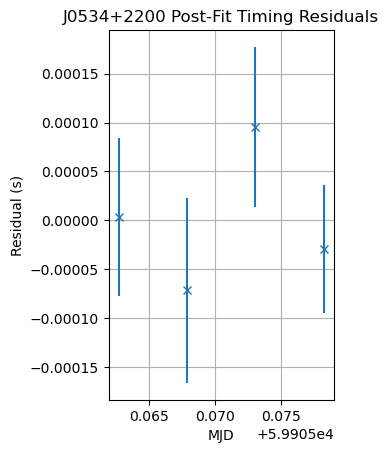

In [9]:
print("Post-fit residual max value = "+str(f.resids.time_resids.to(u.us).value.max()))
print("All TOA pre-fit residuals max value = "+str(rs.resids.to(u.us).value.max()))

plt.subplot(121)
plt.plot(xt.value, rs.resids, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()

plt.subplot(122)
plt.errorbar(
    xt.value,
    f.resids.time_resids.to(u.s).value,
    t_all.get_errors().to(u.s).value,
    fmt="x",
)
plt.title(f"{m.PSR.value} Post-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()

This is a pretty great result already! You can really see that the somewhat-sinusoidal pattern evident in the pre-fit residuals is no longer there, and the residuals are much closer to the scatter around zero that we anticipate (by an entire order of magnitude!). This means our model is now a much better fit to the observed data, as the model predictions of when the pulses should arrive are closer to the actual values of observed TOAs. 

You may have noticed that we only fit all the TOAs in the previous run, rather than fitting only those in our slice of acceptable TOA errors. We can do that now (though since we only removed one TOA we don't anticipate a ton of deviation in these results -- for a more robust test, you can go back up and play with the upper bound of the error (thus removing more TOAs) and see how that affects our result). 

In [10]:
# Creating PINT fitter object "f"
f_cut = pint.fitter.Fitter.auto(t, m)
# Fitting the TOAs by changing model parameters and reevaluating if the chi-square value improves
f_cut.fit_toas()
# Printing summary of the fitting
f_cut.print_summary()

# Printing summary of old fit as a reference!
f.print_summary()

Fitted model using downhill_wls method with 1 free parameters to 4 TOAs
Prefit residuals Wrms = 566.617116300222 us, Postfit residuals Wrms = 57.60899748727304 us
Chisq = 2.155 for 2 d.o.f. for reduced Chisq of 1.077

PAR                   Prefit                  Postfit            Units
============== ==================== ============================ =====
PSR                      J0534+2200 J0534+2200                   None
EPHEM                         DE405 DE405                        None
CLOCK                               TT(BIPM2021)                 None
UNITS                           TDB TDB                          None
START                                                    59905.1 d 
FINISH                                                   59905.1 d 
RM                           -45.44                              rad / m2 
DILATEFREQ                        N                              None
DMDATA                            N                              None
NTOA     

We can plot these side-by-side to see how our fits are impacted by the cut size:

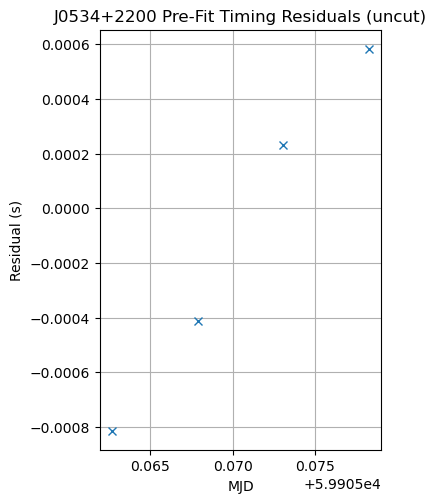

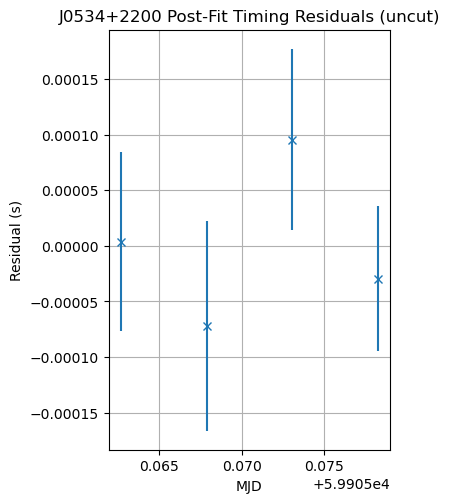

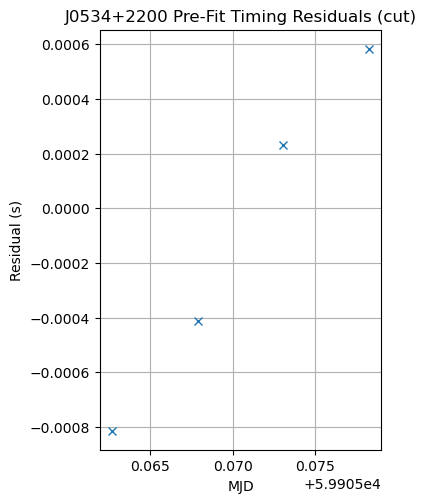

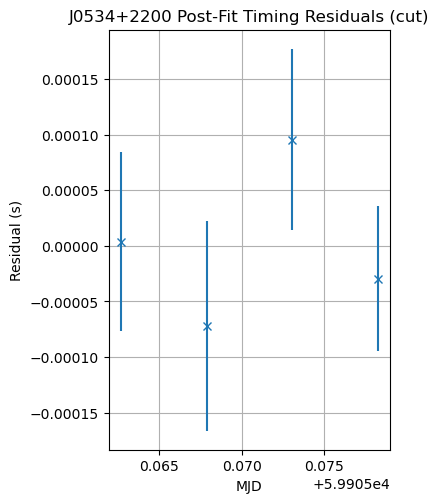

In [11]:
plt.figure(figsize=(8, 12))
plt.subplot(221)
plt.plot(xt.value, rs.resids, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals (uncut)")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()
plt.figure(figsize=(8, 12))
plt.subplot(222)
plt.errorbar(
    xt.value,
    f.resids.time_resids.to(u.s).value,
    t_all.get_errors().to(u.s).value,
    fmt="x",
)
plt.title(f"{m.PSR.value} Post-Fit Timing Residuals (uncut)")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()
plt.figure(figsize=(8, 12))
plt.subplot(223)
plt.plot(xt_cut, rs_cut.resids, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals (cut)")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()
plt.figure(figsize=(8, 12))
plt.subplot(224)
plt.errorbar(
    xt_cut.value,
    f_cut.resids.time_resids.to(u.s).value,
    t.get_errors().to(u.s).value,
    fmt="x",
)
plt.title(f"{m.PSR.value} Post-Fit Timing Residuals (cut)")
plt.xlabel("MJD")
plt.ylabel("Residual (s)")
plt.grid()
plt.show()

Looks like the fits are just about the same for the initial example, though again you can go back and fiddle with the cut threshold to try other cuts. Once you're satisfied with whatever fit you've chosen, you can save the parameters as a .par file using the command **f.model.write_parfile('output_name.par')**. 

That's all for the basics! One good thing to try is building up a timing solution using smaller segments of data at a time -- this can done by starting with a single observation of TOAs, saving the best fit parameter file, and using that new .par file to fit a .tim file made by adding the first observation with another observation. This approach will make sure that our timing solution converges even when the parameters are changing significantly over a set of observations!